### [Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)

### [Removing Low-Variance Features](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold)
- The simplest baseline FS method. It removes all features whose variance fails to meet a threshold value. Zero-variance features are removed by default.
- Example:
    - Boolean-featured dataset (Bernoulli random variables: variance = $\mathrm{Var}[X] = p(1 - p)$
    - Goal: remove all features with either 0 or 1 in >80% of the samples
    - Method should remove the 1st column because it has 5/6>0.8 chance of containing a zero.

In [49]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

### Univariate Selection
- Selects the best features based on a statistical test:
    - [Select K Best](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) - removes all but the $k$ highest-scoring features.
    - [Select by Percentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) - removes all but the highest-scoring features using a [**False Positive Rate**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFpr.html#sklearn.feature_selection.SelectFpr), [**False Discovery Rate**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html#sklearn.feature_selection.SelectFdr) or [**Family-Wise Error Rate**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFwe.html#sklearn.feature_selection.SelectFwe) metric.
    - [Select Generic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect) - removes features via a configurable parameter search estimator.

- Regression tests:
    - [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) - returns `F` (array of feature values), `pval` (array of F-scores)
    - [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) - returns `mi` (array of estimated mutual information between each feature and the target)
- Example scoring functions (for classifications):
    - [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) - returns `chi2` (array of chi2 stats for each feature) and `pval` (array of p-values for each feature)
    - [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)
    - [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

### Example: Univariate Selection
- Iris dataset with noise added to non-informative features
- For each feature, plot p-values from feature selection & corresponding weights from an SVM.
- Should show FS selecting the informative features, and matching the larger SVM weights.

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [31]:
# iris dataset with noise added to informative features
X, y = load_iris(return_X_y=True)
E    = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))
X    = np.hstack((X, E))

X_train, X_test, y_train, y_test = TTS(X, y, stratify=y, random_state=0)
X_indices = np.arange(X.shape[-1])

In [34]:
# Univariate feature selection with F-test for feature scoring
# Use default to select 4 most significant features

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

Classification accuracy:
Without selecting features: 0.789
After univariate feature selection: 0.868


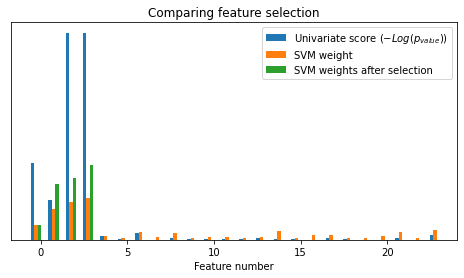

In [45]:
clf          = make_pipeline(MinMaxScaler(),                              LinearSVC())
clf_selected = make_pipeline(SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC())

clf.fit(         X_train, y_train)
clf_selected.fit(X_train, y_train)

svm_weights           = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights          /= svm_weights.sum()
svm_weights_selected  = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

print('Classification accuracy:')
print('Without selecting features: {:.3f}'.format(clf.score(X_test, y_test)))
print('After univariate feature selection: {:.3f}'.format(clf_selected.score(X_test, y_test)))

plt.figure(figsize=(8,4))
plt.bar(X_indices - .45,      
        scores, width=.2, label=r'Univariate score ($-Log(p_{value})$)')
plt.bar(X_indices - .25, 
        svm_weights, width=.2, label='SVM weight')
plt.bar(X_indices[selector.get_support()] - .05, 
        svm_weights_selected, width=.2, label='SVM weights after selection')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

### Example: Using F-test vs Mutual Information statistics
- Plot dependency of y against 3 features (x_1, x_2, x_3) and normalized univariate F-test statistics.
- F-test only captures linear dependency - so it should rate x_1 as the most discriminative.
- Mutual info can capture any dependency - so it should rate x_2 as the most discriminative.
- Both methods should mark x_3 as irrelevant.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(          X, y); f_test /= np.max(f_test)
mi        = mutual_info_regression(X, y); mi     /= np.max(mi)

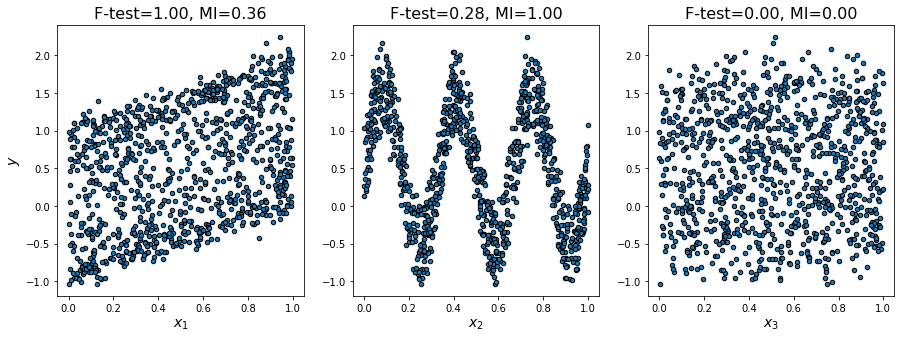

In [48]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()


### [Recursive Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)

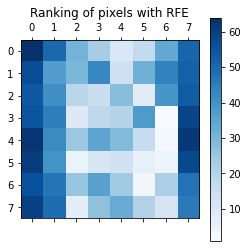

In [19]:
# example - show pixel relevance in digit classification
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

### [Selecting from a Model](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)
- Features that fail a numerical `threshold` value are removed.
- You can also use statistical arguments including "mean", "median", and "0.1*mean".
- You can also use `max_features` to set a limit on the number of selected features.

### Selecting from a Linear Model - L1 norm based selection
- Linear models penalized with L1 norm have sparse solutions - many zero coefficients.
- Use SelectFromModel to reduce model dimensionality before next steps.
- Lasso (regression), Logistic Regression (classification), & LinearSVC (classification) are sparse estimators than can benefit from this approach.
    - Lasso sparsity is controlled via `alpha` (higher alpha = fewer features.)
    - Logistic regression & SVM sparsity is controlled by `C` (smaller C = fewer features).

In [18]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

X, y = load_iris(return_X_y=True)
print(X.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
print(model.transform(X).shape)

(150, 4)
(150, 3)


/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Selecting from a Tree - Impurity based selection

In [15]:
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)

print(X.shape)

clf = ETC(n_estimators=50); clf = clf.fit(X, y); print(clf.feature_importances_)  

model = SelectFromModel(clf, prefit=True)
print(model.transform(X).shape)   

(150, 4)
[0.08051372 0.05626768 0.41688445 0.44633415]
(150, 2)


### [Sequential Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)
- Available in two variations: Forward SS (FSS) and Backward SS (BSS).
- *Forward SS* iteratively finds a best new feature to add to a set of selected features. The procedure stop when the desired #features is found. (controlled by `n_features_to_select`)
- *Backward SS* starts with all features and iteratively removes stragglers.
- `direction` controls the algorithm flow.

In [10]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes(); X, y = diabetes.data, diabetes.target

### Example: Selecting from a Model vs Sequential Selection
- Use cross-validated Lasso
- We only want 2 features, so set `threshold` just above the coefficient of the 3rd most important feature.

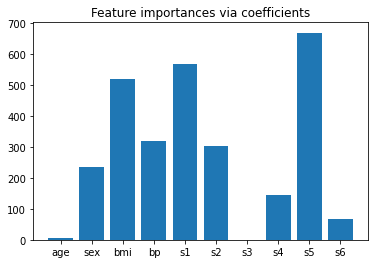

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV

lasso         = LassoCV().fit(X, y)
importance    = np.abs(lasso.coef_)
feature_names = np.array(diabetes.feature_names)

plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [12]:
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-3] + 0.01

tic = time()
sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)
toc = time()
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s1' 's5']
Done in 0.075s


In [13]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

tic_fwd = time()
sfs_forward = SFS(lasso, n_features_to_select=2, direction='forward').fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SFS(lasso, n_features_to_select=2, direction='backward').fit(X, y)
toc_bwd = time()

print("Features (forward SS): " f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features (backward SS): " f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features (forward SS): ['bmi' 's5']
Done in 3.092s
Features (backward SS): ['bmi' 's5']
Done in 8.810s


### Feature Selections & Pipelines
- FS is usually done before learning. Use a [scikit-learn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) to do this.

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LinearSVC())),
                ('classification', RandomForestClassifier())])